In [2]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 52.8 MB 19.3 MB/s eta 0:00:01


In [3]:
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [9]:
import os
#import SimpleITK as sitk
# import nibabel as nib
import copy
import numpy as np
from glob import glob
import time
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import pandas as pd
import cv2
import matplotlib.colors as mcolors
import seaborn as sns
import warnings

In [2]:
ROOT_PATH = './kaggle_3m/'

mask_files = glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0
1,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0
2,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0
3,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0
4,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0
...,...,...,...
3924,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,0
3925,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,0
3926,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,0
3927,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,1


In [4]:
files_df_cp = copy.deepcopy(files_df)
files_df_cp['client'] = [path.split('/')[-1].split('_')[1] for path in files_df_cp['image_path']]
#drop the hospital with only one client
files_df_cp = files_df_cp[files_df_cp['client']!='EZ']
files_df_cp

,image_path,mask_path,diagnosis,client
0,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0,DU
1,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0,DU
2,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0,DU
3,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0,DU
4,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,./kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405...,0,DU
...,...,...,...,...
3924,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,0,HT
3925,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,0,HT
3926,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,0,HT
3927,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,./kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860...,1,HT


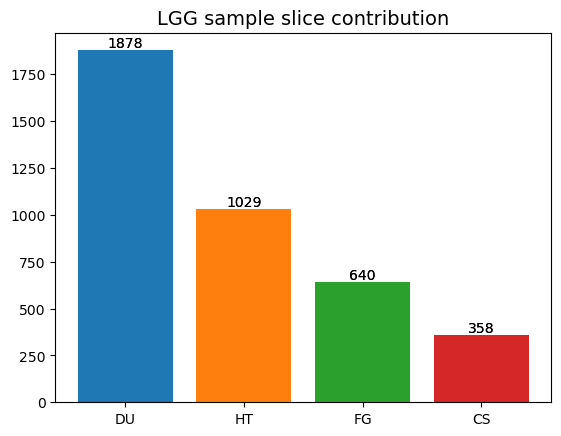

In [16]:
client_df = files_df_cp['client'].value_counts()
fig, ax = plt.subplots()
bars = ax.bar(files_df_cp['client'].value_counts().keys().tolist(), files_df_cp['client'].value_counts().tolist(), color=mcolors.TABLEAU_COLORS)
ax.set_title('LGG sample slice contribution', fontsize=14)
ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)

In [13]:
#client_number = 4
dataname = 'LGG'
img_shape = (256, 256)

#['DU','HT','FG','CS']
client_names = files_df_cp['client'].value_counts().keys().tolist()

for idx, name in enumerate(client_names):
    print(f'Client:{idx+1}')
    client_df = files_df_cp[files_df_cp['client']==name]
    imgs_paths = client_df['image_path'].tolist()
    masks_paths = client_df['mask_path'].tolist()
    
    for data_idx, each_data_path in enumerate(imgs_paths):
        #image
        #img = Image.open(each_data_path)
        img = cv2.imread(each_data_path)
        #img = img.resize(img_shape, Image.Resampling.BICUBIC)
        img_np = np.array(img)
        
        #mask
        mask = np.array(cv2.imread(masks_paths[data_idx], 0))
        mask_prep = np.expand_dims(mask, axis=-1)
        
        #concat image and mask
        data_og = np.concatenate((img_np, mask_prep), axis=-1)
        
        #original image
        np.save('./{}/client{}/data_npy/sample{}'.format(dataname, idx+1, data_idx), data_og)

Client:1
Client:2
Client:3
Client:4


In [ ]:
#client_number = 4
dataname = 'LGG'
img_shape = (256, 256)

#['DU','HT','FG','CS']
client_names = files_df_cp['client'].value_counts().keys().tolist()

for idx, name in enumerate(client_names):
    print(f'Client:{idx+1}')
    client_df = files_df_cp[files_df_cp['client']==name]
    imgs_paths = client_df['image_path'].tolist()
    
    empty_arr = np.zeros((1,256,256,3))
    cnt = 0
    for data_idx, each_data_path in enumerate(imgs_paths):
        #image
        img = cv2.imread(each_data_path)
        img_arr = np.array(img)
        empty_arr[0] += img_arr
        cnt += 1
    mean_arr = empty_arr/cnt
    warnings.filterwarnings('ignore')
    ax = sns.distplot(mean_arr, label=f'{name}')
    
ax.legend()
plt.title('LGG dataset: data distribution of 4 clients', fontsize=14)
plt.show()

Client:1
Client:2
Client:3
Client:4


In [20]:
samp1 = np.load('./LGG/client1/data_npy/sample0.npy')
samp1.shape

(256, 256, 4)